In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

## Checks
Some areas were so small, I assumed a mistake somewhere. So I check the smallest and the 50th smallest parcels on the [official cadastre website](https://cadastre.gouv.fr). Those ridiculous small parcels really exist.


![a](img/smallest-parcel-martinique.png)
![a](img/50th-smallest-parcel-martinique.png)


## Surface retrieval from the cadastre website
On the cadastre website, you can read the parcel area, however the smallest parcel was so small that is was impossible to click on it even at the maximal zoom level. 
Time to get data without UX.

### preparation

    JSESSIONID= # should be like ABCDEF0123456789ABCDEF0123456789.00000
                                 
### get the data from cadastre
    curl 'https://cadastre.gouv.fr/scpc/wfs' -X POST -H "Cookie: JSESSIONID={JSESSIONID}" \ 
        --data-raw '<?xml version="1.0" encoding="UTF-8"?><wfs:GetFeature service="WFS" version="1.0.0" outputFormat="XML-alcer" xmlns:topp="http://www.openplans.org/topp" xmlns:wfs="http://www.opengis.net/wfs" xmlns:ogc="http://www.opengis.net/ogc" xmlns:gml="http://www.opengis.net/gml" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="http://www.opengis.net/wfs http://schemas.opengis.net/wfs/1.0.0/WFS-basic.xsd" maxFeatures="2000"><wfs:Query typeName="CDIF:PARCELLE"><ogc:Filter><ogc:And><ogc:PropertyIsEqualTo><ogc:PropertyName>COMMUNE_IDENT</ogc:PropertyName><ogc:Literal>ZT231</ogc:Literal></ogc:PropertyIsEqualTo><ogc:Intersects><ogc:PropertyName>GEOM</ogc:PropertyName><gml:Box srsName="http://www.opengis.net/gml/srs/epsg.xml#2973"><gml:coordinates>709752.335,1609324.1020000002 709780.335,1609335.638</gml:coordinates></gml:Box></ogc:Intersects></ogc:And></ogc:Filter></wfs:Query></wfs:GetFeature>' > cadastre_info
    
### look for the 3032 parcelle
    cat cadastre_info|sed 's#<PARCELLE #\n<PARCELLE #g'|fgrep C3032|fgrep SURFACE_GEOM --color
    <PARCELLE fid="PARCELLE.ZT2310000C3032"><NATURE>V</NATURE><LIBELLE>3032</LIBELLE><LIBELLEX>709771.33</LIBELLEX><LIBELLEY>1609328.99</LIBELLEY><SURFACE>000000001</SURFACE><SURFACE_GEOM>0.00146484375</SURFACE_GEOM><INDICE>01</INDICE><CODEARPENTAGE>A</CODEARPENTAGE><X_MIN>709770.93</X_MIN><Y_MIN>1609328.7</Y_MIN><X_MAX>709771.82</X_MAX><Y_MAX>1609329.36</Y_MAX><GEOM></GEOM><GEOMVALIDE>0</GEOMVALIDE><APIC_IDENT>1407028</APIC_IDENT><UNITEREF_CODEREF>ZT2310000C</UNITEREF_CODEREF><COMMUNE_IDENT>ZT231</COMMUNE_IDENT><SUBSECTION_IDENT>ZT2310000C01</SUBSECTION_IDENT><inspireId>FR.DGFIP.CADASTRE.PARCELLE.972310000C3032</inspireId><nationalCadastralReference>972310000C3032</nationalCadastralReference><referencePoint></referencePoint><beginLifespanVersion>2022-09-08</beginLifespanVersion></PARCELLE>
    
### retrieve the surface (in square meters):
    cat cadastre_info|sed 's#<PARCELLE #\n<PARCELLE #g'|fgrep C3032|sed -r 's#.*<SURFACE_GEOM>([^<]+)<.*#\1#'
    0.00146484375


In [2]:
!curl https://cadastre.data.gouv.fr/data/etalab-cadastre/2022-10-01/geojson/departements/972/cadastre-972-parcelles.json.gz | gunzip > data-tmp/cadastre-972-parcelles.json

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 29.0M  100 29.0M    0     0  8828k      0  0:00:03  0:00:03 --:--:-- 8831k


In [3]:
gdf_parcelles = gpd.read_file('data-tmp/cadastre-972-parcelles.json')

initial_crs = gdf_parcelles.geometry.crs.srs

In [4]:
gdf_parcelles_m = gdf_parcelles.to_crs('epsg:2973')
gdf_parcelles_m['area'] = gdf_parcelles_m.geometry.area
area_min, area_max = gdf_parcelles_m.area.min(), gdf_parcelles_m.area.max()
print(area_min, area_max)

gdf_parcelles_m = gdf_parcelles_m.sort_values(by='area')
gdf_parcelles_m['cumsum'] = gdf_parcelles_m['area'].cumsum()
gdf_parcelles_m['inside'] = gdf_parcelles_m['cumsum'] <= area_max
print("Number of parcels: ", len(gdf_parcelles_m), 
      "\nNumber of the smallest inside the largest: ", len(gdf_parcelles_m.loc[gdf_parcelles_m.inside]), 
      "\nproportion of the smallest inside the largest: ", round(100 * len(gdf_parcelles_m.loc[gdf_parcelles_m.inside]) / len(gdf_parcelles_m), 2), "%")

gdf_parcelles_m['centroid'] = gdf_parcelles_m.geometry.centroid

0.0004174539163911417 11199633.203121522
Number of parcels:  217607 
Number of the smallest inside the largest:  69186 
proportion of the smallest inside the largest:  31.79 %


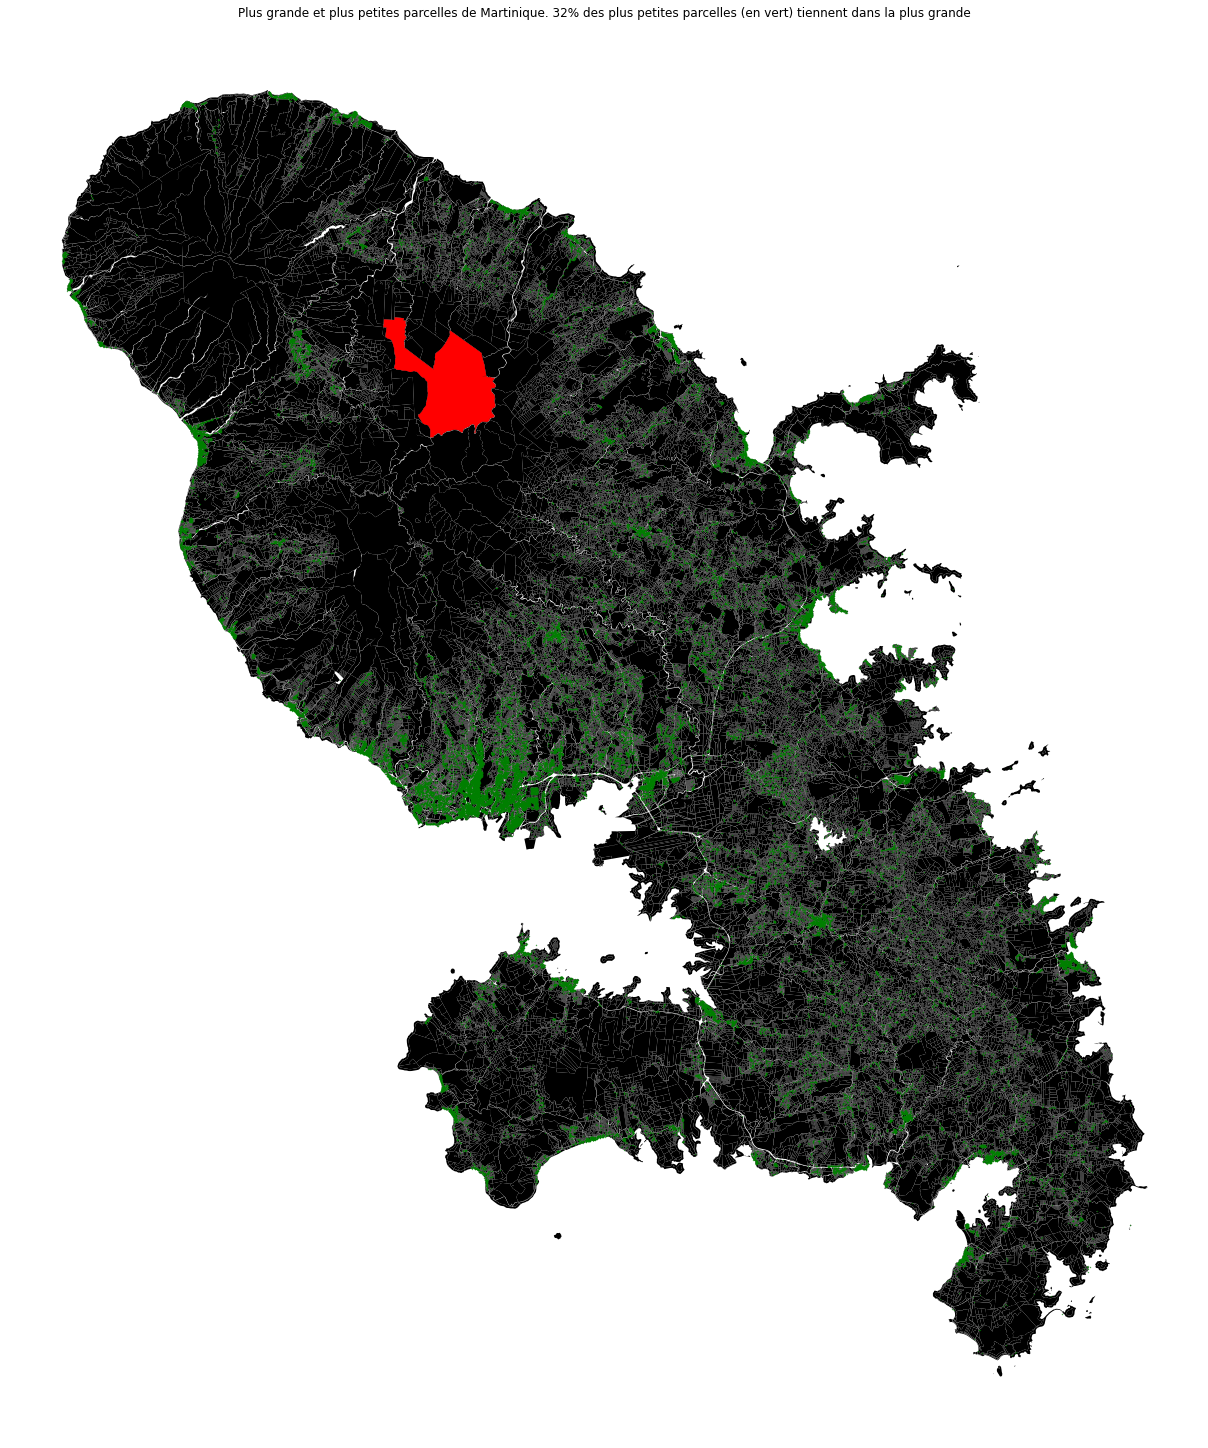

In [5]:
fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(20, 20))
fig.suptitle("Plus grande et plus petites parcelles de Martinique. 32% des plus petites parcelles (en vert) tiennent dans la plus grande",
             backgroundcolor='white', color='black')

gdf_parcelles_m.plot(ax=ax, color='black', linewidth=0)

biggest = gdf_parcelles_m.loc[gdf_parcelles_m.area == area_max]
biggest.plot(ax=ax, color='red')

# show the smallest with dots or with shape. Some areas are so small it makes no sense to show them.
with_dots = True
smallest = gdf_parcelles_m.loc[gdf_parcelles_m.inside].copy()
smallest['geometry'] = smallest['centroid']
if with_dots:
    smallest.plot(ax=ax, color='green', markersize=0.1)
else:
    smallest.plot(ax=ax, color='green', linewidth=0)

ax.axis('off')

plt.savefig('output/2022-11-12.png')